In [1]:
from Config.config import CONFIG
CONFIG = CONFIG("Reddit")

In [2]:
from DyGLib.models.GraphMixer import GraphMixer
from DyGLib.models.TGAT import TGAT
from DyGLib.models.TCL import TCL
from DyGLib.models.CAWN import CAWN
from DyGLib.models.DyGFormer import DyGFormer
from DyGLib.models.MemoryModel import MemoryModel, compute_src_dst_node_time_shifts

from DyGLib.models.modules import TGNN, NeuralNetworkSrcDst, BatchSubgraphs
from DyGLib.utils.DataLoader import get_link_prediction_data
from DyGLib.utils.utils import get_neighbor_sampler, NegativeEdgeSampler

import torch
import numpy as np
import pandas as pd
import seaborn as sns

import random

import graphviz
from IPython.display import SVG
import time

# Initialization

In [3]:
trained_model_path = CONFIG.model.trained_model_path
edge_feat_path = CONFIG.data.folder + CONFIG.data.edge_feat_file
node_feat_path = CONFIG.data.folder + CONFIG.data.node_feat_file
index_path = CONFIG.data.folder + CONFIG.data.index_file
feature_names_path = CONFIG.data.folder + CONFIG.data.feature_names_file

In [4]:
# get data for training, validation and testing
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data = \
    get_link_prediction_data(val_ratio=0.1, test_ratio=0.1, node_dim=CONFIG.model.node_dim)

# initialize validation and test neighbor sampler to retrieve temporal graph
full_neighbor_sampler = get_neighbor_sampler(data=full_data, edge_features=edge_raw_features, sample_neighbor_strategy=CONFIG.model.sample_neighbor_strategy,
                                                time_scaling_factor=CONFIG.model.time_scaling_factor, seed=1)
train_neighbor_sampler = get_neighbor_sampler(data=train_data, edge_features=edge_raw_features, sample_neighbor_strategy=CONFIG.model.sample_neighbor_strategy,
                                                time_scaling_factor=CONFIG.model.time_scaling_factor, seed=1)

# create model
if CONFIG.model.model_name == 'TGAT':
    dynamic_backbone = TGAT(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name in ['JODIE', 'DyRep', 'TGN']:
    # four floats that represent the mean and standard deviation of source and destination node time shifts in the training data, which is used for JODIE
    src_node_mean_time_shift, src_node_std_time_shift, dst_node_mean_time_shift_dst, dst_node_std_time_shift = \
        compute_src_dst_node_time_shifts(train_data.src_node_ids, train_data.dst_node_ids, train_data.node_interact_times)
    dynamic_backbone = MemoryModel(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                                    time_feat_dim=CONFIG.model.time_feat_dim, model_name=CONFIG.model.model_name, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads,
                                    dropout=CONFIG.model.dropout, src_node_mean_time_shift=src_node_mean_time_shift, src_node_std_time_shift=src_node_std_time_shift,
                                    dst_node_mean_time_shift_dst=dst_node_mean_time_shift_dst, dst_node_std_time_shift=dst_node_std_time_shift, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'CAWN':
    dynamic_backbone = CAWN(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, position_feat_dim=CONFIG.model.position_feat_dim, walk_length=CONFIG.model.walk_length,
                            num_walk_heads=CONFIG.model.num_walk_heads, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'TCL':
    dynamic_backbone = TCL(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads,
                            num_depths=CONFIG.model.num_neighbors + 1, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'GraphMixer':
    dynamic_backbone = GraphMixer(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_tokens=CONFIG.model.num_neighbors, num_layers=CONFIG.model.num_layers, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'DyGFormer':
    dynamic_backbone = DyGFormer(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                                    time_feat_dim=CONFIG.model.time_feat_dim, channel_embedding_dim=CONFIG.model.channel_embedding_dim, patch_size=CONFIG.model.patch_size,
                                    num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads, dropout=CONFIG.model.dropout,
                                    max_input_sequence_length=CONFIG.model.max_input_sequence_length, device=CONFIG.model.device)
else:
    raise ValueError(f"Wrong value for model_name {CONFIG.model.model_name}!")

regressor = NeuralNetworkSrcDst(input_dim=node_raw_features.shape[1], num_layers=CONFIG.model.num_reg_layers, hidden_dim=CONFIG.model.hidden_reg_layers_dim)
model = TGNN(dynamic_backbone, regressor)

The dataset has 672447 interactions, involving 10984 different nodes
The training dataset has 435435 interactions, involving 9633 different nodes
The validation dataset has 67245 interactions, involving 9242 different nodes
The test dataset has 67245 interactions, involving 9028 different nodes
The new node validation dataset has 14378 interactions, involving 3239 different nodes
The new node test dataset has 14782 interactions, involving 3151 different nodes
1098 nodes were used for the inductive testing, i.e. are never seen during training


In [5]:
model.load_state_dict(torch.load(trained_model_path, weights_only=True))
model.to(CONFIG.model.device)
model.eval()

TGNN(
  (backbone): TGAT(
    (time_encoder): TimeEncoder(
      (w): Linear(in_features=1, out_features=100, bias=True)
    )
    (temporal_conv_layers): ModuleList(
      (0-1): 2 x MultiHeadAttention(
        (query_projection): Linear(in_features=272, out_features=272, bias=False)
        (key_projection): Linear(in_features=444, out_features=272, bias=False)
        (value_projection): Linear(in_features=444, out_features=272, bias=False)
        (layer_norm): LayerNorm((272,), eps=1e-05, elementwise_affine=True)
        (residual_fc): Linear(in_features=272, out_features=272, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (projectors): ModuleList(
      (0-1): 2 x Linear(in_features=444, out_features=172, bias=True)
    )
  )
  (model): NeuralNetworkSrcDst(
    (model): Sequential(
      (0): Linear(in_features=344, out_features=172, bias=True)
      (1): ReLU()
      (2): Linear(in_features=172, out_features=1, bias=True)
    )
  )
)

## Select edges

In [6]:
num_samples = 200

In [7]:
def get_edge_by_id(link_index):
    src, dst, time_stamp, edge_id, true_value = full_data.src_node_ids[link_index], full_data.dst_node_ids[link_index], full_data.node_interact_times[link_index], full_data.edge_ids[link_index], 1 # type: ignore
    return src, dst, time_stamp, edge_id, true_value

In [8]:
random.seed(2025)

sampled_edge_ids = random.sample((np.where((~np.isnan(full_data.labels)) & (~np.isin(full_data.edge_ids, train_data.edge_ids)))[0]).tolist(), num_samples)

edge_info_array = np.array([list(get_edge_by_id(i)) for i in sampled_edge_ids])
edge_info = pd.DataFrame(edge_info_array, columns=["Src", "Dst", "Time", "Event", "Target"])

edges = edge_info["Event"].to_numpy(dtype=int)

edge_info["InTrain"] = np.isin(edges, train_data.edge_ids)
edge_info = edge_info.sort_values(by="InTrain").reset_index(drop=True)
edge_info = edge_info[edge_info.InTrain == False]

srcs = edge_info["Src"].to_numpy(dtype=int)
dsts = edge_info["Dst"].to_numpy(dtype=int)
timestamps = edge_info["Time"].to_numpy(dtype="float64")
targets = edge_info["Target"].to_numpy(dtype="float32")

In [9]:
model.eval()

subgraphs_src = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers, srcs, timestamps, num_neighbors = CONFIG.model.num_neighbors)
subgraphs_dst = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers, dsts, timestamps, num_neighbors = CONFIG.model.num_neighbors)
edge_feat_src = full_neighbor_sampler.get_edge_features_for_multi_hop(subgraphs_src[1])
edge_feat_dst = full_neighbor_sampler.get_edge_features_for_multi_hop(subgraphs_dst[1])

subgraphs_src = BatchSubgraphs(*subgraphs_src, edge_feat_src)
subgraphs_src.to(CONFIG.model.device)
subgraphs_dst = BatchSubgraphs(*subgraphs_dst, edge_feat_dst)
subgraphs_dst.to(CONFIG.model.device)

predicts = model(src_node_ids=srcs,
                dst_node_ids=dsts,
                node_interact_times=timestamps,
                src_subgraphs = subgraphs_src,
                dst_subgraphs = subgraphs_dst,
                time_gap=CONFIG.model.time_gap,
                edges_are_positive=True).squeeze(dim=-1).sigmoid()

edge_info["Prediction"] = predicts.detach().cpu().numpy()
edge_info

,Src,Dst,Time,Event,Target,InTrain,Prediction
0,4632.0,10006.0,2303458.287,581647.0,1.0,False,0.998958
1,9969.0,10468.0,2315471.742,585177.0,1.0,False,0.761326
2,870.0,10006.0,907622.387,218998.0,1.0,False,0.958368
3,2807.0,10212.0,2242424.197,567113.0,1.0,False,0.891234
4,7179.0,10017.0,2105738.914,529198.0,1.0,False,0.999152
...,...,...,...,...,...,...,...
195,8063.0,10042.0,1798406.448,451096.0,1.0,False,0.998121
196,1631.0,10007.0,2272826.027,573691.0,1.0,False,0.979172
197,6197.0,10153.0,2194095.089,552524.0,1.0,False,0.992656
198,9290.0,10105.0,2544225.219,636006.0,1.0,False,0.998662


In [10]:
timings = []

# Shapley values - Event level

In [11]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerEvents
import shap

c:\Users\LMS\Documents\Masterarbeit\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
explainer = ShapleyExplainerEvents(model, full_neighbor_sampler, full_data, edge_raw_features)

In [13]:
start = time.time_ns()
explainer.initialize()
end = time.time_ns()
timings.append(np.array([[end-start, "Shapley4TGNNEvent", "Init"]]))

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result_shapley_edge, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "Shapley4TGNNEvent"), np.full(exec_times.shape, "Explain")]))
result_shapley_edge["Explainer"] = "Shapley4TGNNEvent"
result_shapley_edge

 66%|██████▌   | 132/200 [08:18<04:13,  3.73s/it]

Exception for 390 to 10176 at 2859.283 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\Shapley4TGNN\Explainer.py", line 90, in explain_instance
    assert len(event_ids) != 0, "The computational subgraph contains no events!"
AssertionError: The computational subgraph contains no events!



100%|██████████| 200/200 [12:31<00:00,  3.76s/it]


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.873,1.000,0.671,0.000,-0.315,-2.767,-0.329,0.000,Zero,Shapley4TGNNEvent
1,0.873,1.000,0.671,0.001,-0.315,-2.767,-0.329,0.000,Zero,Shapley4TGNNEvent
2,0.873,1.000,0.671,0.001,-0.315,-2.767,-0.329,0.000,Zero,Shapley4TGNNEvent
3,0.873,1.000,0.625,0.002,-0.347,-3.020,-0.375,0.000,Zero,Shapley4TGNNEvent
4,0.873,1.000,0.538,0.002,-0.400,-3.504,-0.462,0.000,Zero,Shapley4TGNNEvent
...,...,...,...,...,...,...,...,...,...,...
47,0.873,1.000,0.874,0.998,-0.008,0.013,-0.126,0.753,Mean,Shapley4TGNNEvent
48,0.873,1.000,0.875,0.998,-0.006,0.016,-0.125,0.767,Mean,Shapley4TGNNEvent
49,0.873,1.000,0.875,0.999,-0.005,0.010,-0.125,0.786,Mean,Shapley4TGNNEvent
50,0.873,1.000,0.875,0.999,-0.005,0.010,-0.125,0.786,Mean,Shapley4TGNNEvent


In [15]:
explainer = None
torch.cuda.empty_cache()

# Shapley values - Feature level

In [16]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerFeatures
from Explainers.Shapley4TGNN.Plots import waterfall
import shap
from shap import Explanation

In [17]:
explainer = ShapleyExplainerFeatures(model, full_neighbor_sampler, full_data, edge_raw_features, None, shapley_alg="MonteCarlo", top_k=4)

In [18]:
start = time.time_ns()
explainer.initialize()
end = time.time_ns()
timings.append(np.array([[end-start, "Shapley4TGNNFeature", "Init"]]))

In [19]:
result_shapley_feat, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "Shapley4TGNNFeature"), np.full(exec_times.shape, "Explain")]))
result_shapley_feat["Explainer"] = "Shapley4TGNNFeature"
result_shapley_feat

 66%|██████▌   | 132/200 [11:25:09<5:56:56, 314.95s/it]

Exception for 390 to 10176 at 2859.283 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\Shapley4TGNN\Explainer.py", line 258, in explain_instance
    assert len(event_ids) != 0, "The computational subgraph contains no events!"
AssertionError: The computational subgraph contains no events!



100%|██████████| 200/200 [17:11:58<00:00, 309.59s/it]  


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.873,1.000,0.704,0.000,-0.292,-2.547,-0.296,0.000,Zero,Shapley4TGNNFeature
1,0.873,1.000,0.787,0.002,-0.175,-1.807,-0.213,0.000,Zero,Shapley4TGNNFeature
2,0.873,1.000,0.791,0.003,-0.174,-1.796,-0.209,0.000,Zero,Shapley4TGNNFeature
3,0.873,1.000,0.794,0.004,-0.173,-1.793,-0.206,0.000,Zero,Shapley4TGNNFeature
4,0.873,1.000,0.797,0.005,-0.169,-1.778,-0.203,0.000,Zero,Shapley4TGNNFeature
...,...,...,...,...,...,...,...,...,...,...
47,0.873,1.000,0.873,0.995,-0.009,0.011,-0.127,0.574,Mean,Shapley4TGNNFeature
48,0.873,1.000,0.875,0.996,-0.006,0.026,-0.125,0.903,Mean,Shapley4TGNNFeature
49,0.873,1.000,0.874,0.997,-0.005,0.005,-0.126,0.906,Mean,Shapley4TGNNFeature
50,0.873,1.000,0.875,0.998,-0.003,0.006,-0.125,0.934,Mean,Shapley4TGNNFeature


In [20]:
explainer = None
torch.cuda.empty_cache()

# TGNN Explainer

In [21]:
from Explainers.External.tgnnexplainer.Explainer import SubgraphXTExplainer

In [22]:
explainer = SubgraphXTExplainer(model, full_neighbor_sampler, full_data)

In [23]:
timings.append(np.array([[0, "TGNNExplainer", "Init"]]))

In [24]:
result_tgnnexpl, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "TGNNExplainer"), np.full(exec_times.shape,"Explain")]))
result_tgnnexpl["Explainer"] = "TGNNExplainer"
result_tgnnexpl

 66%|██████▌   | 132/200 [11:11:11<6:34:28, 348.06s/it]

Exception for 390 to 10176 at 2859.283 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\Explainer.py", line 66, in explain_instance
    explain_results = self.explainer(event_idxs=int(edge_id))
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\tgnnexplainer\tgnnexplainer\xgraph\method\subgraphx_tg.py", line 618, in __call__
    tree_nodes, tree_node_x = self.explain(event_idx=event_idx,
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\tgnnexplainer\tgnnexplainer\xgraph\method\subgraphx_tg.py", line 463, in explain
    self.mcts_state_map = MCTS(events=self.ori_subgraph_df,
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\tgnnexplainer\tgnnexplainer\xgraph\method

100%|██████████| 200/200 [16:35:10<00:00, 298.55s/it]  


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.873,1.000,0.671,0.000,-0.315,-2.767,-0.329,0.000,Zero,TGNNExplainer
1,0.873,1.000,0.671,0.001,-0.315,-2.767,-0.329,0.000,Zero,TGNNExplainer
2,0.873,1.000,0.671,0.001,-0.315,-2.767,-0.329,0.000,Zero,TGNNExplainer
3,0.873,1.000,0.671,0.002,-0.315,-2.767,-0.329,0.000,Zero,TGNNExplainer
4,0.873,1.000,0.671,0.002,-0.315,-2.767,-0.329,0.000,Zero,TGNNExplainer
...,...,...,...,...,...,...,...,...,...,...
47,0.873,1.000,0.871,0.998,-0.012,0.026,-0.129,0.749,Mean,TGNNExplainer
48,0.873,1.000,0.870,0.998,-0.008,-0.003,-0.130,0.864,Mean,TGNNExplainer
49,0.873,1.000,0.870,0.999,-0.007,-0.006,-0.130,0.868,Mean,TGNNExplainer
50,0.873,1.000,0.870,0.999,-0.007,-0.006,-0.130,0.868,Mean,TGNNExplainer


In [25]:
explainer = None
torch.cuda.empty_cache()

# TempME

In [26]:
from Explainers.External.TempME.Explainer import TempMEExplainer
from Explainers.External.TempME.utils.graph import get_walk_finder

In [27]:
preprocessing = False

In [28]:
# Preprocessing
if(preprocessing):
    # Preprocessing train data
    explainer = TempMEExplainer(model, train_neighbor_sampler, train_data)
    walk_finder = get_walk_finder(train_data)
    neg_edge_sampler = NegativeEdgeSampler(train_data.src_node_ids, train_data.dst_node_ids, train_data.node_interact_times)

    explainer.preprocess(walk_finder, neg_edge_sampler, train=True)
    # Training
    explainer.initialize(train = True)
    # Preprocessing full data
    explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)
    walk_finder = get_walk_finder(full_data)
    neg_edge_sampler = NegativeEdgeSampler(full_data.src_node_ids, full_data.dst_node_ids, full_data.node_interact_times)

    explainer.preprocess(walk_finder, neg_edge_sampler, train=False)

In [29]:
explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)

In [30]:
# Interference
start = time.time_ns()
explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)
explainer.initialize(train = False)
end = time.time_ns()
timings.append(np.array([[end-start, "TempME", "Init"]]))

In [31]:
result_tempme, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "TempME"), np.full(exec_times.shape, "Explain")]))
result_tempme["Explainer"] = "TempME"
result_tempme

100%|██████████| 200/200 [04:44<00:00,  1.42s/it]


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.883,1.000,0.664,0.000,-0.296,-3.109,-0.336,0.000,Zero,TempME
1,0.883,1.000,0.664,0.001,-0.296,-3.109,-0.336,0.000,Zero,TempME
2,0.883,1.000,0.664,0.001,-0.296,-3.109,-0.336,0.000,Zero,TempME
3,0.883,1.000,0.578,0.002,-0.372,-3.695,-0.422,0.000,Zero,TempME
4,0.883,1.000,0.483,0.002,-0.439,-4.246,-0.517,0.000,Zero,TempME
...,...,...,...,...,...,...,...,...,...,...
47,0.883,1.000,0.884,0.998,-0.004,0.006,-0.116,0.856,Mean,TempME
48,0.883,1.000,0.884,0.998,-0.003,0.004,-0.116,0.857,Mean,TempME
49,0.883,1.000,0.884,0.999,-0.003,0.004,-0.116,0.858,Mean,TempME
50,0.883,1.000,0.884,0.999,-0.003,0.004,-0.116,0.858,Mean,TempME


In [32]:
explainer = None
torch.cuda.empty_cache()

# Evaluation

In [33]:
from Config.colors import PALLETTE2, PRIMARYCOLOR
import matplotlib.pyplot as plt

In [34]:
df = pd.concat([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat])
df.head()

,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.883,1.000,0.664,0.000,-0.296,-3.109,-0.336,0.000,Zero,TempME
1,0.883,1.000,0.664,0.001,-0.296,-3.109,-0.336,0.000,Zero,TempME
2,0.883,1.000,0.664,0.001,-0.296,-3.109,-0.336,0.000,Zero,TempME
3,0.883,1.000,0.578,0.002,-0.372,-3.695,-0.422,0.000,Zero,TempME
4,0.883,1.000,0.483,0.002,-0.439,-4.246,-0.517,0.000,Zero,TempME


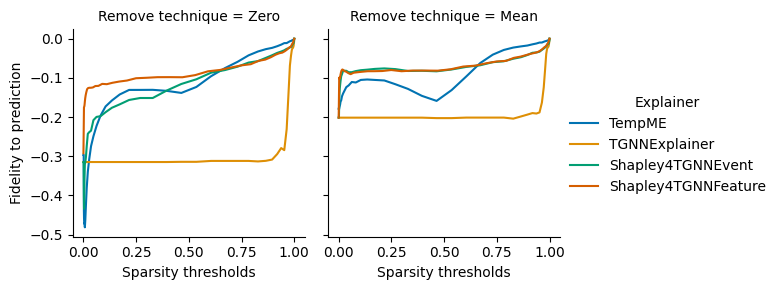

In [35]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_curve.png", bbox_inches='tight')

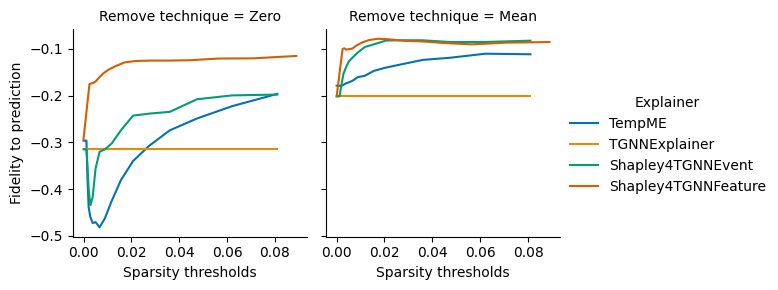

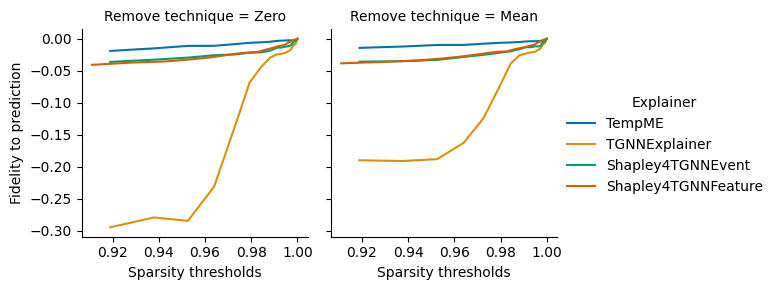

In [36]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_curve_upper_part.png", bbox_inches='tight')
plt.show()

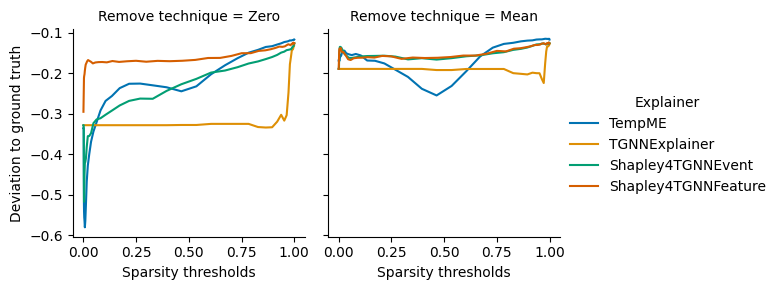

In [37]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Reddit/Deviation_curve.png", bbox_inches='tight')

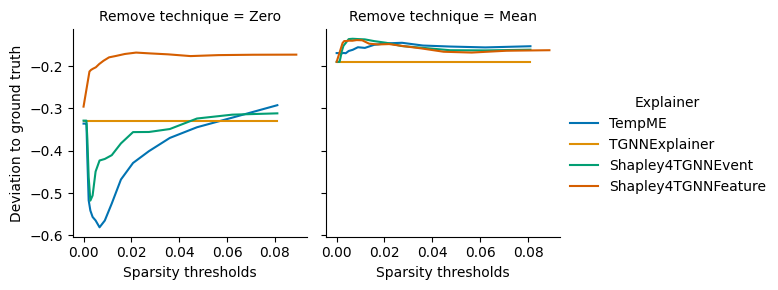

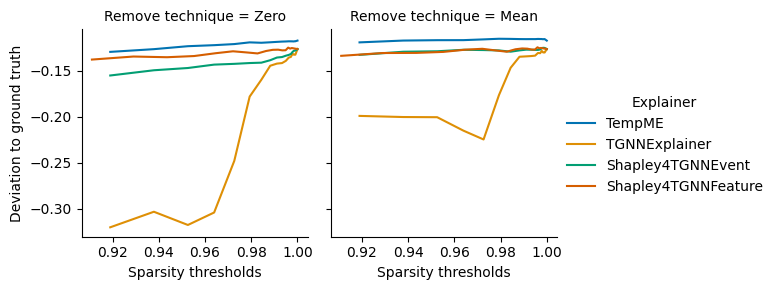

In [38]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Reddit/Deviation_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Reddit/Deviation_curve_upper_part.png", bbox_inches='tight')
plt.show()

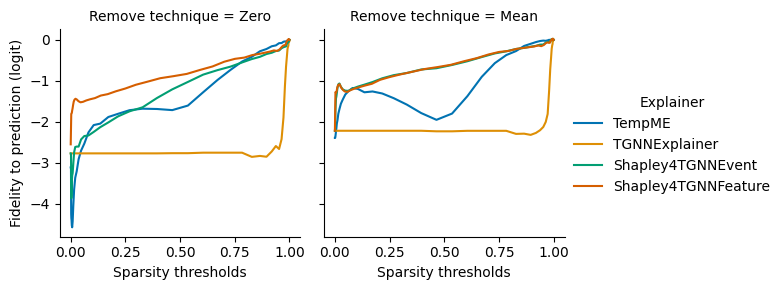

In [39]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_logit_curve.png", bbox_inches='tight')

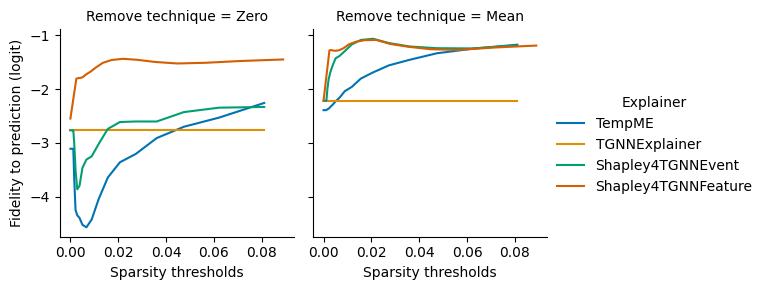

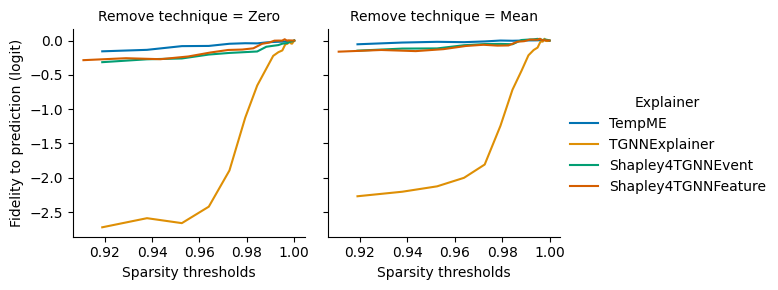

In [40]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_logit_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_logit_curve_upper_part.png", bbox_inches='tight')
plt.show()

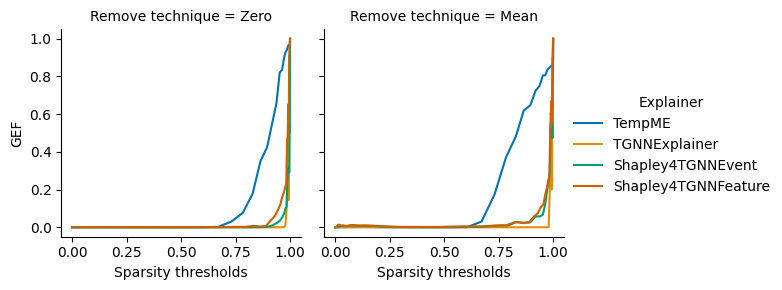

In [41]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Reddit/GEF_curve.png", bbox_inches='tight')

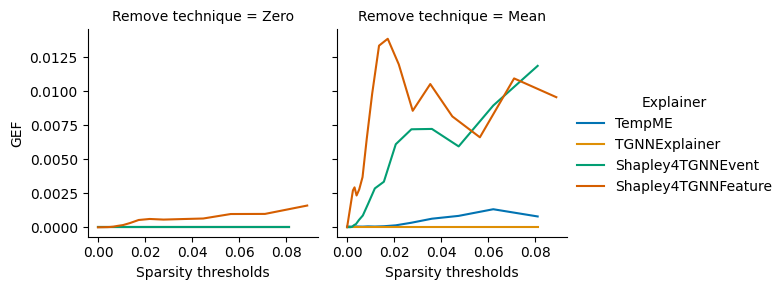

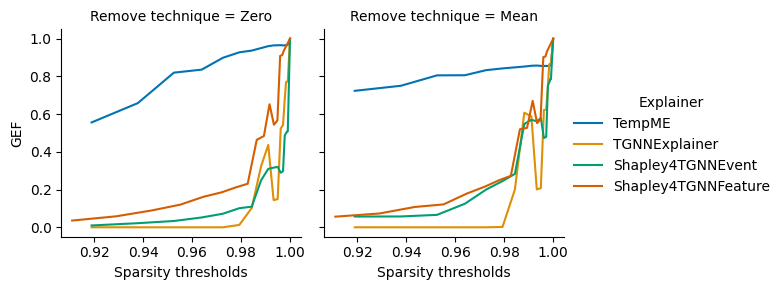

In [42]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Reddit/GEF_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Reddit/GEF_curve_upper_part.png", bbox_inches='tight')
plt.show()

## AUCs

In [43]:
from Explainers.utils import calc_auc

auc_fid_log_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction (logit)", "Zero")
auc_fid_log_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction (logit)", "Mean")
auc_fid_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction", "Zero")
auc_fid_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction", "Mean")
auc_dev_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Deviation to ground truth", "Zero")
auc_dev_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Deviation to ground truth", "Mean")
auc_gef_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "GEF", "Zero")
auc_gef_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "GEF", "Mean")

print(f"AUC for Fidelity (logit) using Zero: {auc_fid_log_zero}")
print(f"AUC for Fidelity (logit) using Mean: {auc_fid_log_mean}")
print("")
print(f"AUC for Fidelity using Zero: {auc_fid_zero}")
print(f"AUC for Fidelity using Mean: {auc_fid_mean}")
print("")
print(f"AUC for Deviation using Zero: {auc_dev_zero}")
print(f"AUC for Deviation using Mean: {auc_dev_mean}")
print("")
print(f"AUC for GEF: {auc_gef_zero}")
print(f"AUC for GEF: {auc_gef_mean}")

text_zero=f"""
\\parbox[t]{{5mm}}{{\\multirow{{4}}{{*}}{{\\rotatebox[origin=c]{{90}}{{Reddit}}}}}} & TGNN Explainer & {round(auc_fid_zero[1],4)} & {round(auc_fid_log_zero[1],4)} & {round(auc_dev_zero[1],4)} & {round(auc_gef_zero[1],4)} \\\\
& TempME & {round(auc_fid_zero[0],4)} & {round(auc_fid_log_zero[0],4)} & {round(auc_dev_zero[0],4)} & {round(auc_gef_zero[0],4)} \\\\
& Shapley (Event) & {round(auc_fid_zero[2],4)} & {round(auc_fid_log_zero[2],4)} & {round(auc_dev_zero[2],4)} & {round(auc_gef_zero[2],4)}\\\\
& Shapley (Feature) & {round(auc_fid_zero[3],4)} & {round(auc_fid_log_zero[3],4)} & {round(auc_dev_zero[3],4)} & {round(auc_gef_zero[3],4)}\\\\
"""

print(text_zero)

text_mean=f"""
\\parbox[t]{{5mm}}{{\\multirow{{4}}{{*}}{{\\rotatebox[origin=c]{{90}}{{Reddit}}}}}} & TGNN Explainer & {round(auc_fid_mean[1],4)} & {round(auc_fid_log_mean[1],4)} & {round(auc_dev_mean[1],4)} & {round(auc_gef_mean[1],4)} \\\\
& TempME & {round(auc_fid_mean[0],4)} & {round(auc_fid_log_mean[0],4)} & {round(auc_dev_mean[0],4)} & {round(auc_gef_mean[0],4)} \\\\
& Shapley (Event) & {round(auc_fid_mean[2],4)} & {round(auc_fid_log_mean[2],4)} & {round(auc_dev_mean[2],4)} & {round(auc_gef_mean[2],4)} \\\\
& Shapley (Feature) & {round(auc_fid_mean[3],4)} & {round(auc_fid_log_mean[3],4)} & {round(auc_dev_mean[3],4)} & {round(auc_gef_mean[3],4)} \\\\
"""

print(text_mean)

AUC for Fidelity (logit) using Zero: [np.float64(3.2025798974232824), np.float64(1.8688183697091587), np.float64(3.3411597476791965), np.float64(3.7266856291887507)]
AUC for Fidelity (logit) using Mean: [np.float64(3.4571639978798205), np.float64(2.3886934721451625), np.float64(3.9379834236531095), np.float64(3.9374669632500225)]

AUC for Fidelity using Zero: [np.float64(0.3699715463167657), np.float64(0.17804291824778928), np.float64(0.3664517244547041), np.float64(0.39559695950862406)]
AUC for Fidelity using Mean: [np.float64(0.3919612906577003), np.float64(0.2856189950026168), np.float64(0.4122901259740127), np.float64(0.41219957069680035)]

AUC for Deviation using Zero: [np.float64(0.36566554120587696), np.float64(0.258208085988567), np.float64(0.3521983084091505), np.float64(0.41896362472428944)]
AUC for Deviation using Mean: [np.float64(0.4061890123275371), np.float64(0.38932892715147605), np.float64(0.4263480640282649), np.float64(0.42706868570580214)]

AUC for GEF: [np.float64(

## Timings

In [44]:
timings = np.concat(timings)
df_timings = pd.DataFrame(timings, columns=["Time", "Explainer", "Action"])

In [45]:
df_timings.loc[:,"Time"] = df_timings.Time.astype(float)/1000000

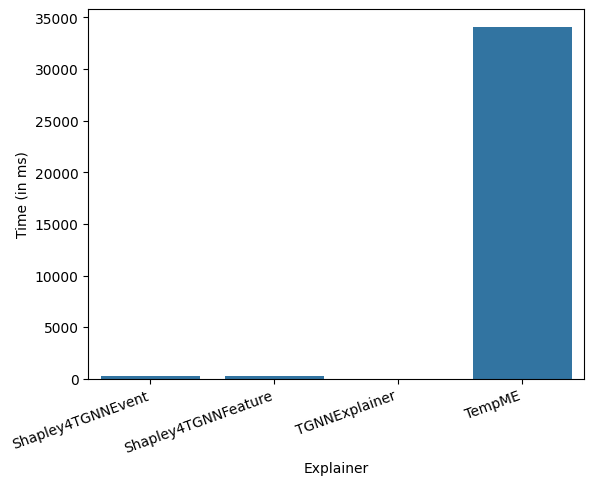

In [46]:
import matplotlib.pyplot as plt

p = sns.barplot(df_timings[df_timings.Action=="Init"], y="Time", x="Explainer", color=PRIMARYCOLOR)
p.set(ylabel="Time (in ms)", )
plt.xticks(rotation=20, horizontalalignment='right')
p.get_figure().savefig("Documents/Images/Reddit/Timings_init.png", bbox_inches='tight')

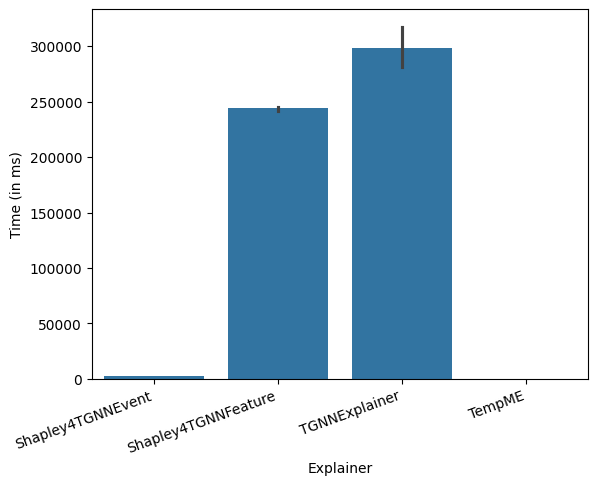

In [47]:
p = sns.barplot(df_timings[df_timings.Action=="Explain"], y="Time", x="Explainer", color=PRIMARYCOLOR)
p.set(ylabel="Time (in ms)", )
plt.xticks(rotation=20, horizontalalignment='right')
p.get_figure().savefig("Documents/Images/Reddit/Timings_expl.png", bbox_inches='tight')